# Hybrid Search 

Leveraging Pinecone's DENSE and SPARSE vector embeddings at the same time through BM25 and Clip (information )
to generate embeddings from fashion products to search across both text and image product descriptions at the same time.  

Hybrid search which is the ability to combine vector semantic search with traditional keyword text search against different modalities for the same entity.

![Screenshot 2024-03-28 at 4.13.13 PM.png](<attachment:Screenshot 2024-03-28 at 4.13.13 PM.png>)

In Pinecone, for any give row or index, you can store dense and sparse vectors at the same time into one row. 

Alpha param will be tuned inside that query to change whether we weigh the results from the BM25 encoding or the Clip encoding more or less. 
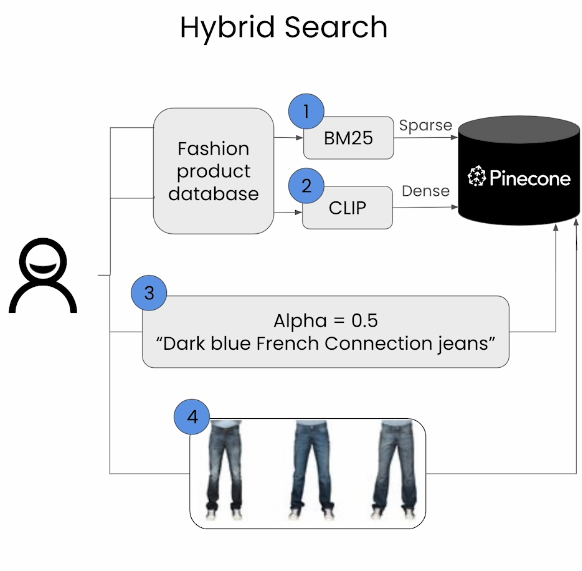

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datasets import load_dataset
from pinecone_text.sparse import BM25Encoder
from pinecone import Pinecone, ServerlessSpec
from DLAIUtils import Utils

from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import torch
import os

In [3]:
utils = Utils()
PINECONE_API_KEY = utils.get_pinecone_api_key()

## Setup Pinecone 

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

utils = Utils()
INDEX_NAME = utils.create_dlai_index_name('dl-ai')
# Create instance of Pinecone object
pinecone = Pinecone(api_key=PINECONE_API_KEY)

if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)
pinecone.create_index(
  INDEX_NAME,
  dimension=512,
  metric="dotproduct",
  spec=ServerlessSpec(cloud='aws', region='us-west-2')
)
index = pinecone.Index(INDEX_NAME)

cpu


## Load Dataset 

Loading the fashion dataset 

In [5]:
# Load fashion dataset from Hugging Face 
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

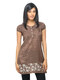

In [6]:
images = fashion['image']
metadata = fashion.remove_columns('image')
# Look up image at the 900th element in the dataset
images[900]

In [7]:
# Convert into Pandas data format
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


## Create the Sparse Vector using BM25 

**BM25:**
![Screenshot 2024-03-28 at 4.37.30 PM.png](<attachment:Screenshot 2024-03-28 at 4.37.30 PM.png>)

**CLIP:**
![Screenshot 2024-03-28 at 4.39.03 PM.png](<attachment:Screenshot 2024-03-28 at 4.39.03 PM.png>)
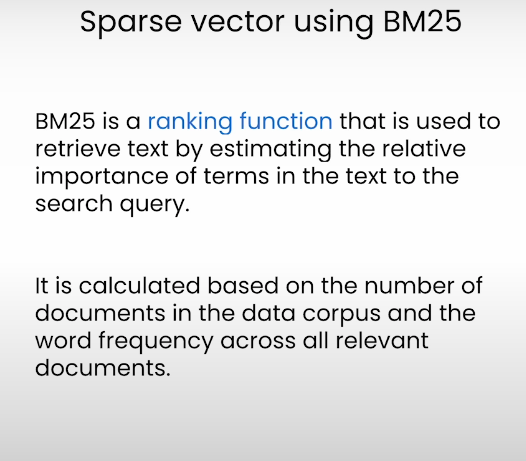
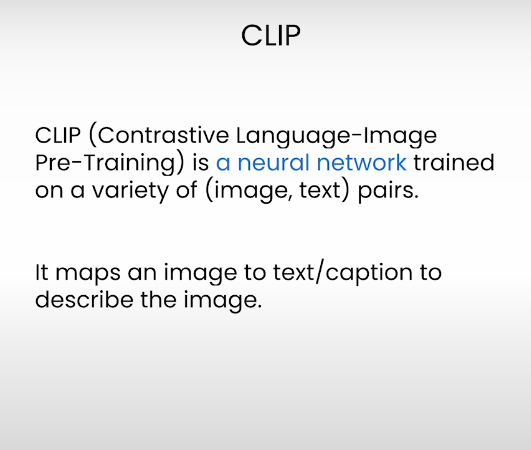

In [8]:
bm25 = BM25Encoder()
bm25.fit(metadata['productDisplayName'])
metadata['productDisplayName'][0]

  0%|          | 0/44072 [00:00<?, ?it/s]

'Turtle Check Men Navy Blue Shirt'

In [9]:
bm25.encode_queries(metadata['productDisplayName'][0])
bm25.encode_documents(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

## Create the Dense Vector Using CLIP

In [10]:
model = SentenceTransformer('sentence-transformers/clip-ViT-B-32', 
    device=device)
model
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

2024-03-28 18:03:32.836448: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(1, 512)

In [11]:
# Check how many elements in our fashion dataset 
len(fashion)

44072

## Create Embeddings Using Sparse and Dense 

In [12]:
batch_size = 200
fashion_data_num = 1000

for i in tqdm(range(0, min(fashion_data_num,len(fashion)), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatenate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

  0%|          | 0/5 [00:00<?, ?it/s]

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 800}},
 'total_vector_count': 800}

## Run Your Query 

In [13]:
query = "dark blue french connection jeans for men"

sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)

# Extract the images from the result
imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>]

In [14]:
# We do want to view these image results 
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# Helper function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


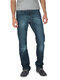
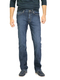
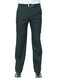
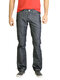
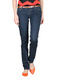
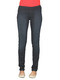
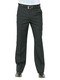
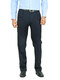
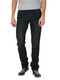
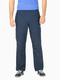
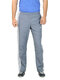
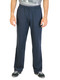
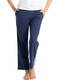
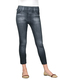

In [15]:
display_result(imgs)

## Scaling the Hybrid Search 

In [16]:
# Helper function that would control through alpha param to scale the dense and sparse vectors, whether we rely more on dense or sparse vectors
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

## Let's try more Dense 


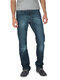
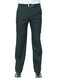
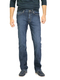
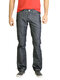
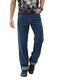
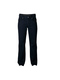

In [25]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [26]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Peter England Men Party Blue Jeans
John Miller Men Reglur Black Trousers
Lee Men Blue Chicago Fit Jeans
Locomotive Men Washed Blue Jeans
Lee Men Blue Chicago Fit Jeans
Gini and Jony Boys Solid Black Jeans


## More Sparse 


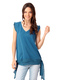
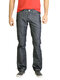
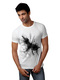
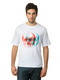
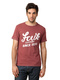
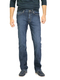
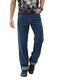
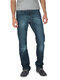
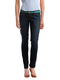
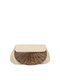

In [21]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
result = index.query(
    top_k=10,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [22]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Women Blue Top
Locomotive Men Washed Blue Jeans
French Connection Men White T-shirt
French Connection Men White T-shirt
French Connection Men Maroon T-shirt
Lee Men Blue Chicago Fit Jeans
Lee Men Blue Chicago Fit Jeans
Peter England Men Party Blue Jeans
Denizen Women Blue Jeans
French Connection Women Beige Clutch


As you can see it appears the more sparse the query the more inaccurate the results are.